# PCA-LDA DATASET ECOLI

Notebook ini bertujuan untuk menganalisis dataset Ecoli yang tersimpan di database MySQL. Dataset Ecoli berisi beberapa fitur numerik yang menggambarkan karakteristik protein, dan sebuah label kelas yang menunjukkan lokasi subselular protein tersebut (misalnya cp, im, om, dll).

Analisis ini menggunakan dua metode reduksi dimensi:

Principal Component Analysis (PCA)

Linear Discriminant Analysis (LDA)

Keduanya akan digunakan untuk memproyeksikan data berdimensi tinggi (7 fitur) ke dalam ruang dua dimensi, sehingga distribusi data antar kelas dapat divisualisasikan.

   id_protein  feature1  feature2  feature3  feature4  feature5  feature6  \
0   AAT_ECOLI      0.49      0.29      0.48       0.5      0.56      0.24   
1  ACEA_ECOLI      0.07      0.40      0.48       0.5      0.54      0.35   
2  ACEK_ECOLI      0.56      0.40      0.48       0.5      0.49      0.37   
3  ACKA_ECOLI      0.59      0.49      0.48       0.5      0.52      0.45   
4   ADI_ECOLI      0.23      0.32      0.48       0.5      0.55      0.25   

   feature7 class_label  
0      0.35          cp  
1      0.44          cp  
2      0.46          cp  
3      0.36          cp  
4      0.35          cp  
Distribusi kelas sebelum balancing: {'cp': 143, 'im': 77, 'imL': 2, 'imS': 2, 'imU': 35, 'om': 20, 'omL': 5, 'pp': 52}


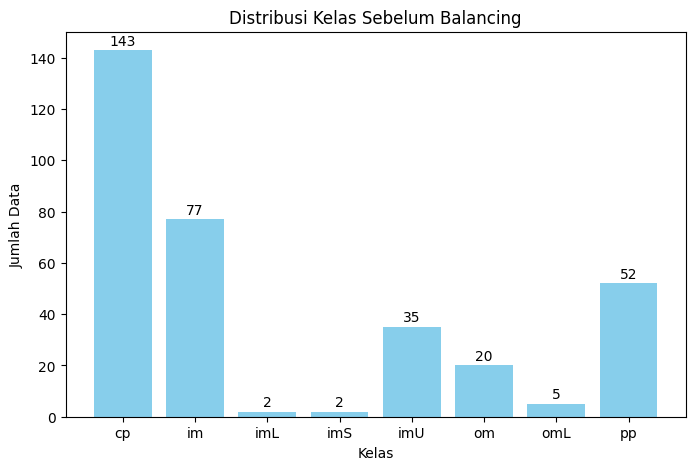

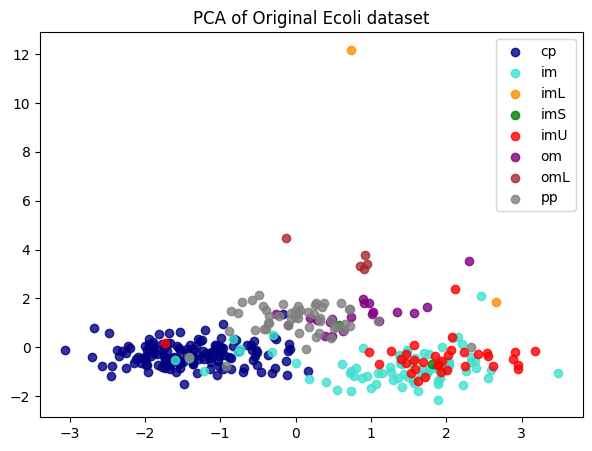

Distribusi kelas sesudah balancing: {'cp': 143, 'im': 143, 'imL': 143, 'imS': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}


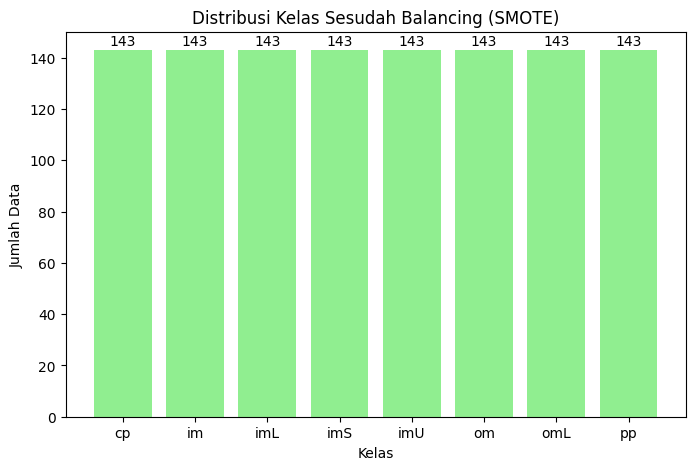

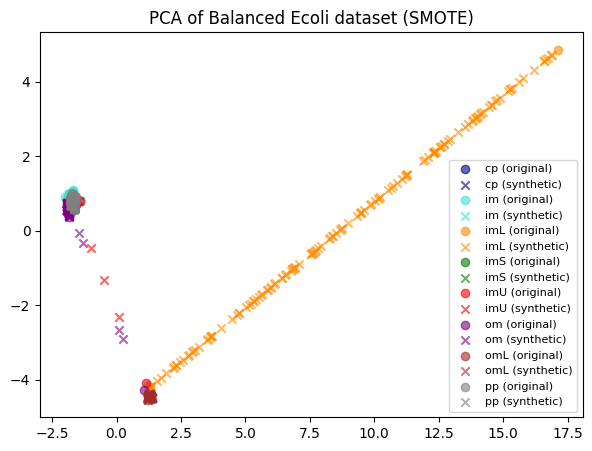


=== Evaluasi Naive Bayes Sebelum Balancing ===
Akurasi: 0.7821782178217822
              precision    recall  f1-score   support

          cp       0.91      1.00      0.96        43
          im       0.78      0.61      0.68        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.62      0.50      0.56        10
          om       0.00      0.00      0.00         6
         omL       0.50      1.00      0.67         1
          pp       0.62      1.00      0.76        16

    accuracy                           0.78       101
   macro avg       0.43      0.51      0.45       101
weighted avg       0.73      0.78      0.74       101



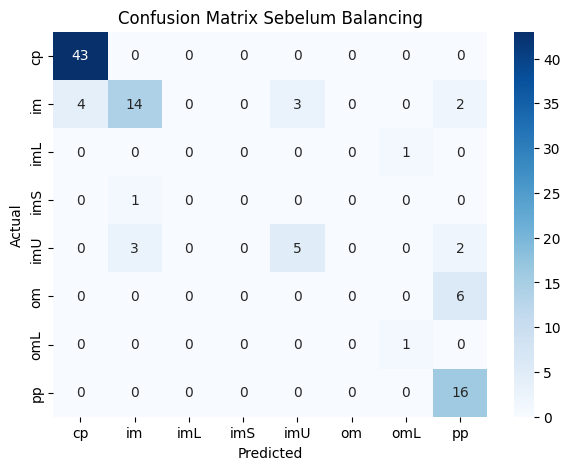


=== Evaluasi Naive Bayes Sesudah Balancing ===
Akurasi: 0.8226744186046512
              precision    recall  f1-score   support

          cp       0.84      1.00      0.91        43
          im       0.88      0.49      0.63        43
         imL       1.00      1.00      1.00        43
         imS       0.96      1.00      0.98        43
         imU       0.73      0.74      0.74        43
          om       1.00      0.40      0.57        43
         omL       1.00      1.00      1.00        43
          pp       0.53      0.95      0.68        43

    accuracy                           0.82       344
   macro avg       0.87      0.82      0.81       344
weighted avg       0.87      0.82      0.81       344



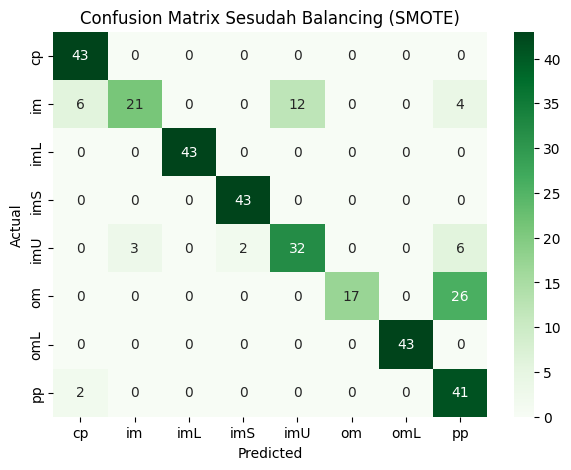

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# === KONEKSI KE MYSQL ===
engine = create_engine("mysql+pymysql://root:@localhost/ecoli")

# === AMBIL DATA ===
df = pd.read_sql("SELECT * FROM ecoli", engine)

# tampilkan 5 baris pertama
print(df.head())

# === PISAHKAN FITUR DAN LABEL ===
X = df[["feature1","feature2","feature3","feature4","feature5","feature6","feature7"]].values
y_raw = df["class_label"].values

# encode label
le = LabelEncoder()
y = le.fit_transform(y_raw)
target_names = le.classes_

# Standarisasi fitur (Naive Bayes bisa lebih stabil dengan ini)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Distribusi kelas sebelum balancing ===
unique, counts = np.unique(y, return_counts=True)
dist_before = dict(zip(le.classes_, counts))
print("Distribusi kelas sebelum balancing:", dist_before)

plt.figure(figsize=(8,5))
plt.bar(dist_before.keys(), dist_before.values(), color="skyblue")
for i, val in enumerate(dist_before.values()):
    plt.text(i, val+2, str(val), ha='center')
plt.title("Distribusi Kelas Sebelum Balancing")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

# === PCA DATA ASLI ===
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(7,5))
colors = ["navy","turquoise","darkorange","green","red","purple","brown","gray"]
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, label=target_name)
plt.legend(loc="best")
plt.title("PCA of Original Ecoli dataset")
plt.show()

# === SMOTE untuk penyeimbangan data ===
smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

# Distribusi kelas sesudah balancing
unique_res, counts_res = np.unique(y_res, return_counts=True)
dist_after = dict(zip(le.inverse_transform(unique_res), counts_res))
print("Distribusi kelas sesudah balancing:", dist_after)

plt.figure(figsize=(8,5))
plt.bar(dist_after.keys(), dist_after.values(), color="lightgreen")
for i, val in enumerate(dist_after.values()):
    plt.text(i, val+2, str(val), ha='center')
plt.title("Distribusi Kelas Sesudah Balancing (SMOTE)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

# === PCA DATA BALANCED ===
X_r_bal = pca.fit(X_res).transform(X_res)
is_synthetic = np.array([False]*len(y) + [True]*(len(X_res)-len(y)))

plt.figure(figsize=(7,5))
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    # titik asli
    plt.scatter(
        X_r_bal[(y_res == i) & (is_synthetic == False), 0],
        X_r_bal[(y_res == i) & (is_synthetic == False), 1],
        color=color, alpha=0.6, label=f"{target_name} (original)"
    )
    # titik synthetic
    plt.scatter(
        X_r_bal[(y_res == i) & (is_synthetic == True), 0],
        X_r_bal[(y_res == i) & (is_synthetic == True), 1],
        color=color, alpha=0.6, marker="x", label=f"{target_name} (synthetic)"
    )
plt.legend(loc="best", fontsize=8)
plt.title("PCA of Balanced Ecoli dataset (SMOTE)")
plt.show()

# === KLASIFIKASI SEBELUM BALANCING ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf_before = GaussianNB()
clf_before.fit(X_train, y_train)
y_pred_before = clf_before.predict(X_test)

print("\n=== Evaluasi Naive Bayes Sebelum Balancing ===")
print("Akurasi:", accuracy_score(y_test, y_pred_before))
print(classification_report(y_test, y_pred_before, target_names=target_names, zero_division=0))

# Confusion Matrix sebelum balancing
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_before), annot=True, fmt="d",
            xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.title("Confusion Matrix Sebelum Balancing")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === KLASIFIKASI SESUDAH BALANCING ===
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)
clf_after = GaussianNB()
clf_after.fit(X_train_res, y_train_res)
y_pred_after = clf_after.predict(X_test_res)

print("\n=== Evaluasi Naive Bayes Sesudah Balancing ===")
print("Akurasi:", accuracy_score(y_test_res, y_pred_after))
print(classification_report(y_test_res, y_pred_after, target_names=target_names, zero_division=0))

# Confusion Matrix sesudah balancing
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test_res, y_pred_after), annot=True, fmt="d",
            xticklabels=target_names, yticklabels=target_names, cmap="Greens")
plt.title("Confusion Matrix Sesudah Balancing (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Dalam proyek ini, dataset Ecoli yang digunakan memiliki distribusi kelas yang sangat tidak seimbang. Sebagai contoh, beberapa kelas minoritas ekstrem hanya memiliki 2–5 sampel, sedangkan kelas mayoritas memiliki lebih dari 100 sampel:

{'cp': 143, 'im': 77, 'imL': 2, 'imS': 2, 'imU': 35, 'om': 20, 'omL': 5, 'pp': 52}

Awalnya, penyeimbangan data dicoba menggunakan ADASYN, karena metode ini dapat membuat sampel synthetic yang fokus pada titik-titik minoritas yang sulit dipelajari (hard-to-learn). Namun, ADASYN memerlukan jumlah sampel minoritas minimal 3 untuk mencari tetangga dari kelas mayoritas.

Dalam dataset ini, kelas imL dan imS hanya memiliki 2 sampel, sehingga ADASYN gagal mengeksekusi proses penyeimbangan dan menghasilkan error:

RuntimeError: Not any neighbours belong to the majority class...

Untuk mengatasi hal ini, dipilih SMOTE (Synthetic Minority Over-sampling Technique) sebagai metode penyeimbangan. SMOTE tetap bisa bekerja untuk kelas minoritas yang sangat kecil dengan cara:

Membuat sampel synthetic dengan menginterpolasi antara titik minoritas dan tetangga terdekatnya.

Memungkinkan pengaturan k_neighbors secara manual, sehingga dapat disesuaikan dengan jumlah sampel minoritas (dalam kasus ini, k_neighbors=1).

Dengan SMOTE, semua kelas minoritas, termasuk yang memiliki sangat sedikit sampel, dapat dibuatkan sampel synthetic dengan aman tanpa error, sehingga dataset menjadi lebih seimbang dan siap untuk analisis atau pemodelan berikutnya.